In [1]:
import pandas as pd
import numpy as np
import json
import random

from tqdm import tqdm

Arquivo csv adaptado para diminuir trabalho com tratamento de dados

In [2]:
url = "https://raw.githubusercontent.com/LucasAzvd/teoria-da-decis-o/main/data/i5x25.csv?token=AI4MMZ5LFVT2YERE7VVKHHLBXKDD6"
df = pd.read_csv(url)
df.head(2)

,tarefa,maq_1,maq_2,maq_3,maq_4,maq_5,peso,due_date
0,1,2,1,4,7,8,8,6
1,2,8,3,2,1,5,5,6


# Funções objetivo

## Min F1(x)

\begin{equation}
minf_{1}(x)= C_{max} = max\left (\sum_{j=1}^{N}\sum_{k=1}^{N} t_{ij}x_{ijk}  \right )\\
i\epsilon\left\{ i,...,M \right \}
\end{equation}

Essa função nos trás o tempo de execução máximo de uma máquina, somando todas as tarefas que foram executadas na mesma.   
Seu retorno é representado pelo maior tempo de execução das máquinas e sua minimização 

In [3]:
def min_f1(df_alocacao: pd.DataFrame) -> dict:
    """Minimizar o makespan, calculando o tempo de execução em todas as máquinas 
            e retornando a que mais demora
    Args
        df_alocacao[pd.DataFrame]: Dataframe com a alocação das máquinas
    Returns:
        int : O maior tempo de execução das máquinas
    """

    tempo_maximo_atual = max(df_alocacao.iloc[:, 1:6].sum())
    
    return tempo_maximo_atual

## Min F2(x)

\begin{equation}
minf_{2}(x)= \sum_{j=1}^{N} w_{j}t_{j}
\end{equation}

Se refere a soma ponderada dos atrasos que ocorreram com a penalidade $W_{j}$.

In [4]:
def min_f2(df_alocacao):
    df_alocacao['penalidade'] = df_alocacao.iloc[:, 1:6].max(axis=1)
    df_alocacao['penalidade'] = df_alocacao['penalidade'] - df_alocacao['due_date']
    df_alocacao.loc[df_alocacao['penalidade'] < 0, 'penalidade'] = 0
    df_alocacao['penalidade'] = df_alocacao['penalidade']*df_alocacao['peso']

    penalidade = max(df_alocacao.drop(['tarefa', 'peso', 'due_date'], axis=1).sum())

    return penalidade

## Restrições

Iremos implementar as seguintes restrições na função abaixo:  
`restricao_tarefas_maquinas`
\begin{equation}
 \sum_{i=1}^{M}\sum_{k=1}^{N+1} x_{ijk} = 1,\forall j\epsilon \left \{ 1,...,N \right \}
\end{equation}

`restricao_tempo_máximo`
\begin{equation}
C_{max}\geq  \sum_{i=1}^{M}\sum_{k=1}^{N+1} t_{ij}x_{ijk},\forall i\epsilon \left \{ 1,...,M \right \}
\end{equation}

Restrição redundante para o nosso código. Se trata de validar que um máquina pode ficar sem nenhuma tarefa atribuída.
\begin{equation}
\sum_{k=1}^{N} x_{i0k}\leq 1,\forall i\epsilon \left \{ 1,...,M \right \}
\end{equation}

Restrição redundante para o nosso código. Se trata de verificação de finalização de tarefas antes da atribuição a uma máquina.
\begin{equation}
\sum_{j=1,j\neq h}^{N+1} x_{ijh} - \sum_{k=1,k\neq h}^{N+1} x_{ihk} = 0,\forall h\epsilon \left \{ 1,...,N \right \}e\forall i\epsilon \left \{ 1,...,M \right \}
\end{equation}

Restrição redundante para o nosso código. Se trata se a tarefa está exutando uma tarefa ou não.
\begin{equation}
C_{ik}\geqslant C_{ij} - L + \left ( t_{ij}+L \right )x_{ijk},\forall \text{j e k}\epsilon \left \{ 1,..,N \right \}
\end{equation}

`restricao_tempo_atraso`
\begin{equation}
T_{j}\geq C_{j}-d,\forall j\epsilon \left \{ 1,...,N \right \}
\end{equation}

Caso alguma restrição seja violada, retornamos **True**.

In [5]:
def restricao_tarefas_maquinas(df_alocacao: pd.DataFrame):
    """Cada tarefa deverá ir para uma máquina obrigatoriamente, garantindo que todas as tarefas sejam executadas.
    Nela verificamos de existe alguma linha vazia no nosso dataframe de linhas de execução, que representaria uma tarefa sem alocar.
    Também verificamos se as tarefas são alocadas apenas para uma máquina.
    """
    soma_linhas_dataframe = df_alocacao.iloc[:, 1:6].nunique(axis=1)
    for i in soma_linhas_dataframe:
        if i != 2:  # Restricao violada
            # print("Restrito: restricao_tarefas_maquinas")
            return True

    return False

In [6]:
def restricao_tempo_maximo(df_alocacao: int, tempo_execucao_maquinas: list):
    """Nesta restrição garantimos que o tempo máximo de execução seja respeitado.
    """
    for tempo_exec in np.array(df_alocacao.iloc[:,1:6].sum()):
        if tempo_exec > tempo_execucao_maquinas: # Viola restrição
            # print("Restrito: restricao_tempo_maximo")
            return True
        else:
            return False

In [7]:
def restricao_tempo_atraso(df_alocacao: True):
    """Restrição referente ao tempo de atraso, ela delimita que o tempo de execução
    da tarefa tem que ser limitado pelo tempo d definido."""
    df_aux = df_alocacao.copy()
    df_aux['tempo_atraso'] = df_aux['due_date'] - df_alocacao.iloc[:, 1:6].max(axis=1)
    
    df_aux['restricao_atraso'] = df_aux['tempo_atraso'] - df_aux['due_date'] + df_alocacao.iloc[:, 1:6].max(axis=1)
    if sum(df_aux['restricao_atraso']):
        # print("Restrito: restricao_tempo_atraso")
        return True
    else:
        return False

## Estrutura de vizinhança

1.   Shift
2.   Swtich
3.   Swap
4.   Two-Shift
5.   Task-Move


In [8]:
def swap(df_alocacao: pd.DataFrame, df: pd.DataFrame):
    quant_tarefas = 25
    quant_maquinas = 5
    tarefa_swap_1 = random.randint(1, quant_tarefas)
    if tarefa_swap_1 == quant_tarefas:
        tarefa_swap_2 = tarefa_swap_1 - 1
    else:
        tarefa_swap_2 = tarefa_swap_1 + 1

    tarefa_swap_1_list = df_alocacao[df_alocacao['tarefa']
                                     == tarefa_swap_1].iloc[:, 1:6].values[0].copy()
    tarefa_swap_2_list = df_alocacao[df_alocacao['tarefa']
                                     == tarefa_swap_2].iloc[:, 1:6].values[0].copy()
    for i in range(0, len(tarefa_swap_1_list)):
        if tarefa_swap_1_list[i] > 0:
            maq_1 = i+1
            df_alocacao.loc[df_alocacao["tarefa"]
                            == tarefa_swap_1, f'maq_{i+1}'] = 0

    for i in range(0, len(tarefa_swap_2_list)):
        if tarefa_swap_2_list[i] > 0:
            maq_2 = i+1
            df_alocacao.loc[df_alocacao["tarefa"] ==
                            tarefa_swap_2, f'maq_{maq_2}'] = 0

    df_alocacao.loc[df_alocacao["tarefa"] == tarefa_swap_1,
                    f'maq_{maq_2}'] = df[df["tarefa"] == tarefa_swap_1][f'maq_{maq_2}']
    df_alocacao.loc[df_alocacao["tarefa"] == tarefa_swap_2,
                    f'maq_{maq_1}'] = df[df["tarefa"] == tarefa_swap_2][f'maq_{maq_1}']

    return df_alocacao

In [9]:
def task_move(df_alocacao: pd.DataFrame, df: pd.DataFrame):
    quant_tarefas = 25
    task_to_move = random.randint(1, quant_tarefas)

    list_tasks = df_alocacao[df_alocacao['tarefa'] ==
                             task_to_move].iloc[:, 1:6].values[0].copy()
    for i in range(0, len(list_tasks)):
        if list_tasks[i] > 0:
            maq = i+1
            df_alocacao.loc[df_alocacao["tarefa"]
                            == task_to_move, f'maq_{maq}'] = 0
            if maq == 5:
                df_alocacao.loc[df_alocacao["tarefa"] == task_to_move,
                                f'maq_{maq-1}'] = df[df['tarefa'] == task_to_move][f'maq_{maq-1}']
            else:
                df_alocacao.loc[df_alocacao["tarefa"] == task_to_move,
                                f'maq_{maq+1}'] = df[df['tarefa'] == task_to_move][f'maq_{maq+1}']
            break

    return df_alocacao

In [10]:
def estruturas(df_alocacao, df, k):
    if k==1:
        df_alocacao_new = swap(df_alocacao, df)
    else:
        df_alocacao_new = task_move(df_alocacao, df)
    return df_alocacao_new

## Variáveis

In [11]:
quant_maq = 5
quant_tarefas = df.shape[0]

Alocando as tarefas nas máquinas aleatóriamente

In [12]:
def aloca_tarefas(df_alocacao, quant_tarefas):
    for i in range(0, quant_tarefas):
        maq_aloc = random.randint(1,quant_maq)
        while (df_alocacao[f'maq_{maq_aloc}'].nunique()-1)  == 5:
            maq_aloc = random.randint(1,quant_maq)

        # Pegando tarefa i e atribuindo o valor dela a maquina referente
        df_alocacao.iloc[i][f'maq_{maq_aloc}'] = df[df['tarefa'] == i+1][f'maq_{maq_aloc}'].values[0]
    return df_alocacao


Calculando a penalidade inicial da nossa alocação

In [13]:
def calcula_penalidade(df_alocacao):
    df_alocacao['penalidade'] = 0
    df_alocacao['penalidade'] = df_alocacao.iloc[:, 1:6].max(axis=1)
    df_alocacao['penalidade'] = df_alocacao['penalidade'] - df_alocacao['due_date']
    df_alocacao.loc[df_alocacao['penalidade'] < 0, 'penalidade'] = 0
    df_alocacao['penalidade'] = df_alocacao['penalidade']*df_alocacao['peso']
    return df_alocacao

In [14]:
def gera_alocacao():
    """Gera alocação para as máquinas aleatoriamente"""
    df_alocacao = df.copy()
    df_alocacao['maq_1'] = 0
    df_alocacao['maq_2'] = 0
    df_alocacao['maq_3'] = 0
    df_alocacao['maq_4'] = 0
    df_alocacao['maq_5'] = 0
    df_alocacao = aloca_tarefas(df_alocacao, quant_tarefas)
    df_alocacao = calcula_penalidade(df_alocacao)
    return df_alocacao

## Soma Ponderada

Para aplicação da função de soma ponderada iremos realizar chamadas dos dois modelos de otimização simultaneamente, nisso aplicaremos um peso em cada e gerar o novo resultado. Nosso primeiro peso será 0.5(igual para amas funções) após ele iremos escolher aleatóriamente o valor dos pesos.

In [15]:
def soma_ponderada(peso_1, peso_2, df_alocacao):
    resultado = 0
    tempo_maximo_execucao = min_f1(df_alocacao)
    penalidade_maximo_execucao = min_f2(df_alocacao)
    
    tempo_maximo_execucao = tempo_maximo_execucao*peso_1
    penalidade_maximo_execucao = penalidade_maximo_execucao*peso_2
    
    return tempo_maximo_execucao, penalidade_maximo_execucao

# Execução do nosso algoritmo

In [16]:
def exec_algo(n_execucoes, n_epocas):
    execucoes_dict = {}
    peso_1 = 0.5 # Nossos primeiros pesos são iguais
    peso_2 = 0.5
    for n_exec in range(0, n_execucoes):
        df_alocacao = gera_alocacao()

        list_soma = {}
        list_tempo_maximo = []
        list_penalidade_inicial = [] 
        list_soma_resultante = []
        
        tempo_maximo, penalidade_inicial = soma_ponderada(peso_1, peso_2, df_alocacao)
        soma_resultante = tempo_maximo + penalidade_inicial

        k = 1
        for epc in tqdm(range(0, n_epocas)):
        # for epc in range(0, n_epocas):
            # Gerando novos pesos aleatorios
            peso_1 = random.uniform(0, 1)
            peso_2 = 1 - peso_1 # A soma do peso 1 com o peso 2 é sempre 1
            
            soma_poderada_execucao = soma_resultante
            tempo_maximo_execucao = tempo_maximo
            
            df_alocacao_new = df_alocacao.copy()
            df_alocacao_new = estruturas(df_alocacao, df, k)
            k=1
            restricao_1 = restricao_tarefas_maquinas(df_alocacao_new)
            restricao_2 = restricao_tempo_maximo(df_alocacao_new, tempo_maximo)
            restricao_3 = restricao_tempo_atraso(df_alocacao_new)
            if restricao_1 or restricao_2 or restricao_3:
                # Se alguma restrição verdadeira, adicionamos os valores antigos a lista
                list_tempo_maximo.append(tempo_maximo)
                list_penalidade_inicial.append(penalidade_inicial)
                list_soma_resultante.append(soma_resultante)
                k=0

            else:
                tempo_maximo_execucao, penalidade_execucao = soma_ponderada(peso_1, peso_2, df_alocacao_new)
                soma_poderada_execucao = tempo_maximo_execucao + penalidade_execucao

                if soma_poderada_execucao < soma_resultante:
                    # print("Otimizado")
                    soma_resultante = soma_poderada_execucao
                    tempo_maximo = tempo_maximo_execucao
                    penalidade_inicial = penalidade_execucao
                    df_alocacao = df_alocacao_new.copy()
                
                list_tempo_maximo.append(tempo_maximo)
                list_penalidade_inicial.append(penalidade_inicial)
                list_soma_resultante.append(soma_resultante)

        execucoes_dict[f'{n_exec+1}'] = {'tempo_maximo': list_tempo_maximo, 
                                           'penalidade_inicial': list_penalidade_inicial,
                                           'soma_resultante': list_soma_resultante}

    return execucoes_dict
    

In [17]:
n_epocas = 100
n_execucoes = 5
execucoes_dict = exec_algo(n_execucoes, n_epocas)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.81it/s]


In [18]:
print("Para execução da soma ponderada temos o seguinte resultado:")
for i in execucoes_dict.keys():
    media = np.mean(execucoes_dict[i]['soma_resultante'])
    std = np.std(execucoes_dict[i]['soma_resultante'])
    max_value = np.max(execucoes_dict[i]['soma_resultante'])
    print(f"Para a execução {i} temos média:{round(media, 2)}, desvio padrão:{round(std, 2)} e valor máximo:{max_value}")

Para execução da soma ponderada temos o seguinte resultado:
Para a execução 1 temos média:40.5, desvio padrão:8.09 e valor máximo:118.0
Para a execução 2 temos média:49.31, desvio padrão:18.85 e valor máximo:128.58793554763213
Para a execução 3 temos média:36.35, desvio padrão:3.09 e valor máximo:46.74240171760932
Para a execução 4 temos média:50.03, desvio padrão:19.09 e valor máximo:98.04770862252374
Para a execução 5 temos média:36.48, desvio padrão:1.5 e valor máximo:39.69061317868707


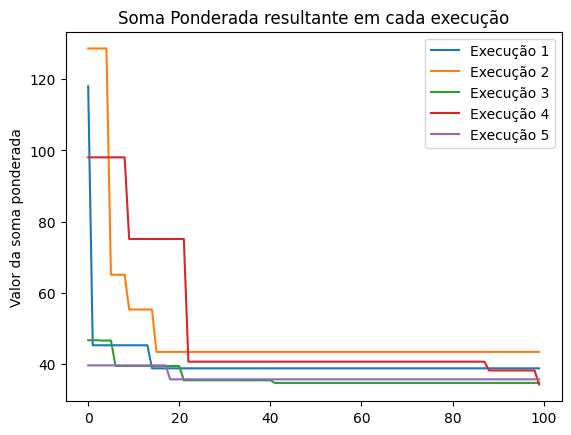

In [24]:
import matplotlib.pyplot as plt

# plt.figure(figsize=(12,5))
plt.plot(execucoes_dict['1']['soma_resultante'], label='Execução 1')
plt.plot(execucoes_dict['2']['soma_resultante'], label='Execução 2')
plt.plot(execucoes_dict['3']['soma_resultante'], label='Execução 3')
plt.plot(execucoes_dict['4']['soma_resultante'], label='Execução 4')
plt.plot(execucoes_dict['5']['soma_resultante'], label='Execução 5')

plt.title("Soma Ponderada resultante em cada execução")
plt.ylabel("Valor da soma ponderada")
plt.legend()
plt.show()

In [20]:
ultima_exec = {}

for i in execucoes_dict.keys():
    ultima_exec[i] = {}

for i in execucoes_dict.keys():
    ultima_exec[i]['tempo_maximo'] = execucoes_dict[i]['tempo_maximo'][-1]
    ultima_exec[i]['penalidade_inicial'] = execucoes_dict[i]['penalidade_inicial'][-1]
    

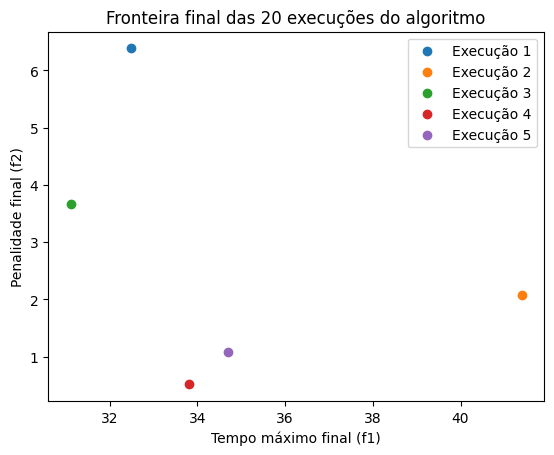

In [23]:
import matplotlib.pyplot as plt

#plt.figure(figsize=(12,5))
plt.scatter(ultima_exec['1']['tempo_maximo'], ultima_exec['1']['penalidade_inicial'], label='Execução 1')
plt.scatter(ultima_exec['2']['tempo_maximo'], ultima_exec['2']['penalidade_inicial'], label='Execução 2')
plt.scatter(ultima_exec['3']['tempo_maximo'], ultima_exec['3']['penalidade_inicial'], label='Execução 3')
plt.scatter(ultima_exec['4']['tempo_maximo'], ultima_exec['4']['penalidade_inicial'], label='Execução 4')
plt.scatter(ultima_exec['5']['tempo_maximo'], ultima_exec['5']['penalidade_inicial'], label='Execução 5')

plt.title("Fronteira final das 20 execuções do algoritmo")
plt.ylabel("Penalidade final (f2)")
plt.xlabel("Tempo máximo final (f1)")
plt.legend()
plt.show()

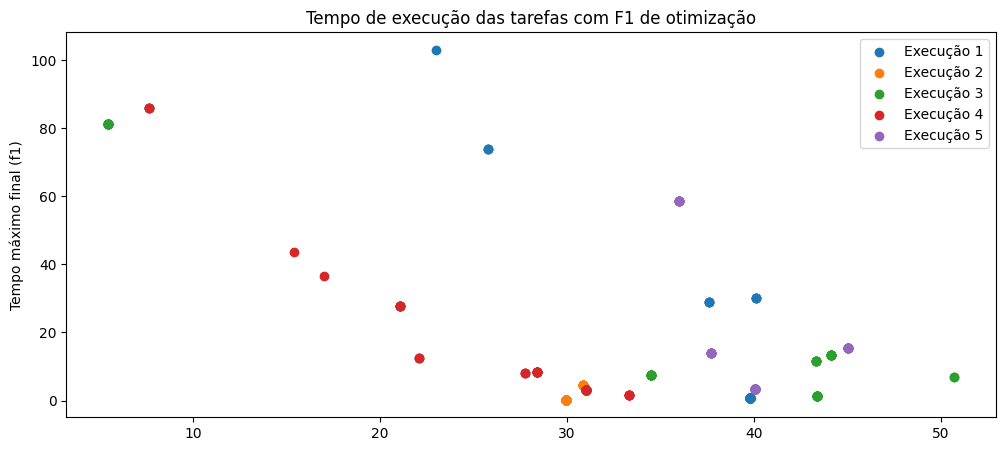

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.scatter(execucoes_dict['1']['tempo_maximo'], execucoes_dict['1']['penalidade_inicial'], label='Execução 1')
plt.scatter(execucoes_dict['2']['tempo_maximo'], execucoes_dict['2']['penalidade_inicial'], label='Execução 2')
plt.scatter(execucoes_dict['3']['tempo_maximo'], execucoes_dict['3']['penalidade_inicial'], label='Execução 3')
plt.scatter(execucoes_dict['4']['tempo_maximo'], execucoes_dict['4']['penalidade_inicial'], label='Execução 4')
plt.scatter(execucoes_dict['5']['tempo_maximo'], execucoes_dict['5']['penalidade_inicial'], label='Execução 5')

plt.title("Tempo de execução das tarefas com F1 de otimização")
plt.ylabel("Penalidade final (f2)")
plt.ylabel("Tempo máximo final (f1)")
plt.legend()
plt.show()

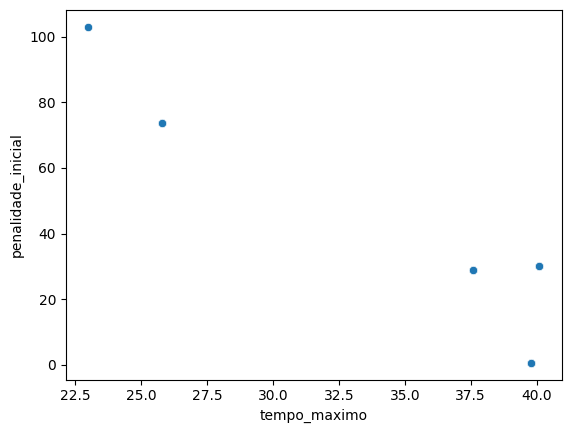

In [23]:
import seaborn as sns
sns.scatterplot(
    data=execucoes_dict['1'], x="tempo_maximo", y="penalidade_inicial",
    sizes=(20, 200), hue_norm=(0, 7), legend="full"
)
plt.show()